# Dependences and imports

In [1]:
%%bash

# install required system dependencies
apt-get install -y xvfb x11-utils

# install required python dependencies (might need to install additional gym extras depending)
pip install -q pyvirtualdisplay PyOpenGL PyOpenGL-accelerate gymnasium==0.29.0

Reading package lists...
Building dependency tree...
Reading state information...
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.15).
The following additional packages will be installed:
  libxtst6 libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxtst6 libxxf86dga1 x11-utils
0 upgraded, 3 newly installed, 0 to remove and 38 not upgraded.
Need to get 232 kB of archives.
After this operation, 819 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxtst6 amd64 2:1.2.3-1build4 [13.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxxf86dga1 amd64 2:1.1.5-0ubuntu3 [12.6 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 x11-utils amd64 7.7+5build2 [206 kB]
Fetched 232 kB in 0s (1,923 kB/s)
Selecting previously unselected package libxtst6:amd64.
(Reading database ... 126675 files and directories currently installed.)
Preparing to unpack .../libxtst6_2%3a1.2.3

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.


In [2]:
import base64
import glob
import io

import gymnasium as gym
import matplotlib.pyplot  as plt
import numpy as np
from gymnasium.wrappers.record_video import RecordVideo
from IPython.display import HTML
from IPython import display as ipythondisplay
from tqdm.notebook import tqdm

# ideia

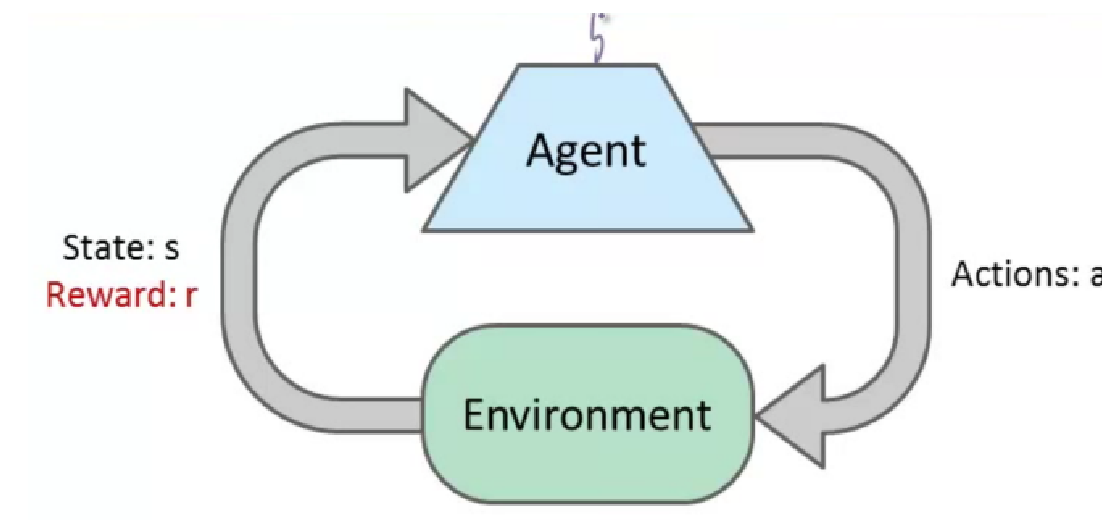

# Display utils

In [3]:
VIDEO_FOLDER = './video/'

In [4]:
def show_video():
    mp4list = glob.glob(f'{VIDEO_FOLDER}/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")


def wrap_env(env):
    env = RecordVideo(env, VIDEO_FOLDER,
                      episode_trigger=lambda episode_number: True)
    return env


# Base simulation

In [5]:
env = wrap_env(gym.make("Taxi-v3", render_mode="rgb_array"))

def base_simulation(env):
    observation = env.reset()

    while True:

        env.render()

        action = env.action_space.sample()

        observation, reward, done, truncated, info = env.step(action)

        if done or truncated:
            break

    env.close()

    show_video()

base_simulation(env)

/usr/local/lib/python3.12/dist-packages/gymnasium/core.py:297: UserWarning: WARN: env.is_vector_env to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.is_vector_env` for environment variables or `env.get_attr('is_vector_env')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"


Moviepy - Building video /content/video/rl-video-episode-0.mp4.
Moviepy - Writing video /content/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-0.mp4


In [6]:
# @markdown <h1>Setting the hyperparameters for Q-learning Taxi</h1>
alpha = 0.8 # @param {type:"slider", min: 0.0, max:1.0, step: 0.01}
discount_factor = 0.1  # @param {type:"slider", min: 0.0, max:1.0, step: 0.01}
train_episodes = 1000  # @param {type:"integer"}
max_steps = 100  # @param {type:"integer"}
min_epsilon = 0.05  # @param {type:"number"}
max_epsilon = 1  # @param {type:"integer"}
epsilon_decay = 0.021   # @param {type:"slider", min: 0.0, max:1.0, step: 0.001}
eval_episodes=10  # @param {type:"integer"}

env = gym.make("Taxi-v3", render_mode="rgb_array")


def q_learning(env, train_episodes = 1000, decay = 0.01, max_steps = 100,
               eval_episodes=10, min_epsilon = 0.05, debug=False):
    Q = np.zeros((env.observation_space.n, env.action_space.n))

    epsilon = 1
    training_rewards = []
    epsilons = []

    for episode in tqdm(range(train_episodes)):
        state, _ = env.reset()
        total_training_rewards = 0

        for step in range(max_steps):
            roulette = np.random.uniform(0, 1)

            action = (np.argmax(Q[state,:]) if roulette > epsilon  # exploit
                      else env.action_space.sample())  # explore

            new_state, reward, done, truncated, info = env.step(action)

            if debug and reward != 0.1:
                print(reward)

            Q[state, action] = (
                (1-alpha) * Q[state, action] +
                alpha  * (reward + discount_factor * Q[new_state, :].max())
            )

            total_training_rewards += reward
            state = new_state

            if done or truncated:
                break

        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay*episode)

        training_rewards.append(total_training_rewards)
        epsilons.append(epsilon)

        if episode % eval_episodes == 0:
            try:
                print(f"Episode {episode:>3}: Accumulated reward: {np.mean(training_rewards[-10:]): 10.2f}")
            except:
                pass

    return Q, training_rewards, epsilons


Q, training_rewards, epsilons = q_learning(
    env, train_episodes, epsilon_decay, max_steps,
    eval_episodes, min_epsilon, debug=False
)

  0%|          | 0/1000 [00:00<?, ?it/s]

Episode   0: Accumulated reward:    -397.00
Episode  10: Accumulated reward:    -336.20
Episode  20: Accumulated reward:    -352.30
Episode  30: Accumulated reward:    -318.70
Episode  40: Accumulated reward:    -270.60
Episode  50: Accumulated reward:    -267.40
Episode  60: Accumulated reward:    -191.30
Episode  70: Accumulated reward:    -218.50
Episode  80: Accumulated reward:    -192.70
Episode  90: Accumulated reward:    -177.10
Episode 100: Accumulated reward:    -145.80
Episode 110: Accumulated reward:    -133.20
Episode 120: Accumulated reward:    -140.10
Episode 130: Accumulated reward:    -125.60
Episode 140: Accumulated reward:    -100.00
Episode 150: Accumulated reward:     -88.50
Episode 160: Accumulated reward:    -109.60
Episode 170: Accumulated reward:     -95.90
Episode 180: Accumulated reward:     -93.10
Episode 190: Accumulated reward:     -74.80
Episode 200: Accumulated reward:     -87.90
Episode 210: Accumulated reward:     -78.40
Episode 220: Accumulated reward:

In [ ]:
Q.shape, Q

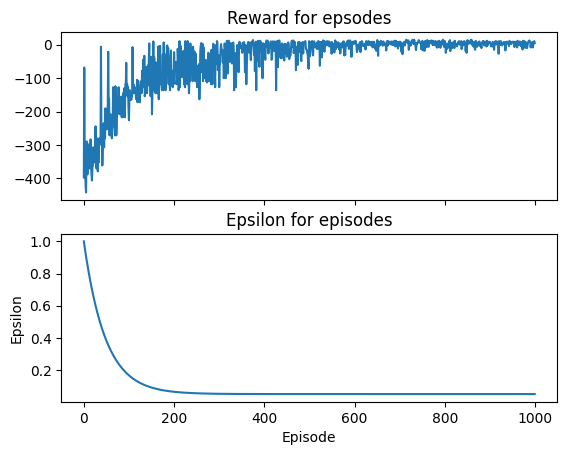

In [7]:
def plot(training_rewards, epsilons):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    ax1.plot(training_rewards)
    ax1.title.set_text('Reward for epsodes')
    plt.ylabel('Training total reward')

    ax2.plot(epsilons)
    ax2.title.set_text("Epsilon for episodes")
    plt.ylabel('Epsilon')
    plt.xlabel('Episode')
    plt.show()


plot(training_rewards, epsilons)

In [8]:
env = wrap_env(gym.make("Taxi-v3", render_mode="rgb_array"))


def simulate_using_Q(env, Q, max_steps=100, debug=False):
    observation, _ = env.reset()

    for _ in range(max_steps):

        env.render()

        action = np.argmax(Q[observation,:])
        if debug:
            print(Q[observation,:])

        observation, reward, done, truncated, info = env.step(action)

        if done or truncated:
            break

    env.close()

    show_video()


simulate_using_Q(env, Q)

/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/core.py:297: UserWarning: WARN: env.is_vector_env to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.is_vector_env` for environment variables or `env.get_attr('is_vector_env')` that will search the reminding wrappers.
  logger.warn(


Moviepy - Building video /content/video/rl-video-episode-0.mp4.
Moviepy - Writing video /content/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-0.mp4


# Discrete Flappy-bird

In [9]:
!pip install -q flappy-bird-gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 40.5 MB/s eta 0:00:00


In [10]:
# @markdown <h1>code for flappy bird enviroment</h1>
import random
from itertools import cycle
from typing import Tuple, Optional

import gymnasium
import pygame
from flappy_bird_gymnasium import FlappyBirdEnv
from flappy_bird_gymnasium.envs.constants import (
    PLAYER_HEIGHT, PLAYER_WIDTH, PIPE_HEIGHT, PIPE_WIDTH, PLAYER_MAX_VEL_Y
)


# quantization = [-.8,-.5, -.3, -.2, -.1, -.05, -0.02, 0.02, .05, .1, .2, .3, .5, .8]
quantizations = {
    'v_dist': [-.15, -.05, 0, .05, .15, .3],
    'player_y': [.2, .6],
    'vel_y': [-.5, -.1, .2, .5],
    'h_dist': [.2]
}


def bound(val, lower=-1, upper=1):
    return max(min(val, upper), lower)

class FlappyBirdDiscreteEnv(FlappyBirdEnv):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 30}

    def __init__(
        self,
        screen_size: Tuple[int, int] = (288, 512),
        pipe_gap: int = 100,
        bird_color: str = "yellow",
        pipe_color: str = "green",
        render_mode: Optional[str] = None,
        background: Optional[str] = "day",
        score_limit: Optional[int] = None,
        debug: bool = False,
    ) -> None:
        super().__init__(screen_size, False, True, False,
                         pipe_gap, bird_color, pipe_color, render_mode, background, score_limit, debug)

        self.shape = (10, 20, 20)
        self.observation_space = gymnasium.spaces.Discrete(7 * 2)


    def _get_observation_features_raw(self):
        up_pipe = low_pipe = None
        h_dist = 0
        prev_dist = -100
        pipes = sorted(zip(self._upper_pipes, self._lower_pipes),
                       key=lambda x: x[0]["x"])

        for up_pipe, low_pipe in pipes:
            h_dist = (low_pipe["x"] + PIPE_WIDTH / 2
                      - (self._player_x - PLAYER_WIDTH / 2))
            h_dist += 5  # extra distance to compensate for the buggy hit-box
            if h_dist >= 0:
                break

            prev_dist = h_dist

        upper_pipe_y = up_pipe["y"] + PIPE_HEIGHT
        lower_pipe_y = low_pipe["y"]
        player_y = self._player_y
        vel_y = self._player_vel_y

        v_dist = (upper_pipe_y + lower_pipe_y) / 2 - (player_y
                                                      + PLAYER_HEIGHT/2)

        h_dist /= self._screen_width
        prev_dist /= self._screen_width

        v_dist /= self._screen_height
        vel_y /= PLAYER_MAX_VEL_Y
        lower_pipe_y /= self._screen_height
        upper_pipe_y /= self._screen_height
        player_y /= self._screen_height

        return prev_dist, h_dist, v_dist, vel_y, lower_pipe_y, upper_pipe_y, player_y

    def _get_observation_features(self):
        (prev_dist, h_dist, v_dist, vel_y,
        lower_pipe_y, upper_pipe_y, player_y) = self._get_observation_features_raw()

        v_dist = np.digitize(v_dist, bins=quantizations['v_dist'])  % 8
        player_y = np.digitize(player_y, bins=quantizations['player_y'])  % 4
        vel_y = np.digitize(vel_y, bins=quantizations['vel_y'])  % 5
        h_dist = np.digitize(h_dist, bins=quantizations['h_dist'])  % 3
        prev_dist = np.digitize(-prev_dist, bins=quantizations['h_dist'])  % 3

        factor = 1
        state = (
            v_dist +
            # player_y * (factor := factor * (len(quantizations['v_dist']) + 1)) +
            # vel_y *    (factor := factor * (len(quantizations['v_dist']) + 1)) +
            h_dist * (factor := factor * (len(quantizations['v_dist']) + 1))
            # 0 if player_y <= lower_pipe_y else (1 if lower_pipe_y <= player_y <= upper_pipe_y else 2)
            # int(bound(h_dist, 0) * 10) +
            # int((bound(v_dist, -0.5, 0.5) + 0.5) * 20) * self.shape[0]
            # int((bound(vel_y) + 1) * 10 * self.shape[0] * self.shape[1])
        )

        return state, None

    def reset(self, seed=None, options=None):
        """Resets the environment (starts a new game)."""
        super().reset(seed=seed)

        self._player_x = int(self._screen_width * .2)
        self._player_y = int((self._screen_height - PLAYER_HEIGHT) / 2)
        # self._player_y = int(self._screen_height * np.random.normal(0.5, 0.1))


        obs, _ = self._get_observation()
        info = {"score": self._score}
        return obs, info

    def step(self, action):
        observation, reward, done, truncated, info  = super().step(action)
        (prev_dist, h_dist, v_dist, vel_y,
        lower_pipe_y, upper_pipe_y, player_y) = self._get_observation_features_raw()


        if 0.05 <= v_dist <= 0.15:
            reward = 0
        elif 0.15 <= v_dist:
            reward = -0.05
        elif 0.3 <= v_dist:
            reward = -0.1

        if action == 1 and vel_y < .1:
            reward =- 0.1

        # elif player_y <= 0.1 or player_y >= 0.6:
        #     reward = 0

        dists.append((v_dist, player_y, vel_y, h_dist))
        return observation, reward, done, truncated, info


dists  = []

# Base simulation

In [13]:
env = wrap_env(FlappyBirdDiscreteEnv(render_mode="rgb_array"))

base_simulation(env)

Moviepy - Building video /content/video/rl-video-episode-0.mp4.
Moviepy - Writing video /content/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-0.mp4


In [ ]:
# @markdown <h1>Setting the hyperparameters for Q-learning Fally Bird</h1>
alpha = 0.5 # @param {type:"slider", min: 0.0, max:1.0, step: 0.01}
discount_factor = 0.99  # @param {type:"slider", min: 0.0, max:1.0, step: 0.01}
train_episodes = 20000  # @param {type:"integer"}
max_steps = 1500  # @param {type:"integer"}
min_epsilon = 0.10  # @param {type:"number"}
max_epsilon = 1  # @param {type:"integer"}
epsilon_decay = 0.473   # @param {type:"slider", min: 0.0, max:1.0, step: 0.001}
eval_episodes=1  # @param {type:"integer"}


dists  = []
env = FlappyBirdDiscreteEnv(render_mode="rgb_array")

Q, training_rewards, epsilons = q_learning(
    env, train_episodes, epsilon_decay, max_steps,
    eval_episodes, min_epsilon, debug=False
)

  0%|          | 0/20000 [00:00<?, ?it/s]

A saída de streaming foi truncada nas últimas 5000 linhas.
Episode 3437: Accumulated reward:       0.79
Episode 3438: Accumulated reward:       0.27
Episode 3439: Accumulated reward:      -0.31
Episode 3440: Accumulated reward:      -0.12
Episode 3441: Accumulated reward:      -0.09
Episode 3442: Accumulated reward:       0.28
Episode 3443: Accumulated reward:      -0.26
Episode 3444: Accumulated reward:      -0.07
Episode 3445: Accumulated reward:      -0.01
Episode 3446: Accumulated reward:      -0.32
Episode 3447: Accumulated reward:      -0.47
Episode 3448: Accumulated reward:      -0.60
Episode 3449: Accumulated reward:      -0.35
Episode 3450: Accumulated reward:      -0.92
Episode 3451: Accumulated reward:      -0.35
Episode 3452: Accumulated reward:      -0.34
Episode 3453: Accumulated reward:       0.70
Episode 3454: Accumulated reward:       0.83
Episode 3455: Accumulated reward:       0.92
Episode 3456: Accumulated reward:       1.58
Episode 3457: Accumulated reward:       1

(array([151571.,  96976.,  79559.,  68511.,  70569.,  54063.,  47957.,
         42807.,  38364.,  44986.]),
 array([-0.9 , -0.71, -0.52, -0.33, -0.14,  0.05,  0.24,  0.43,  0.62,
         0.81,  1.  ]),
 <BarContainer object of 10 artists>)

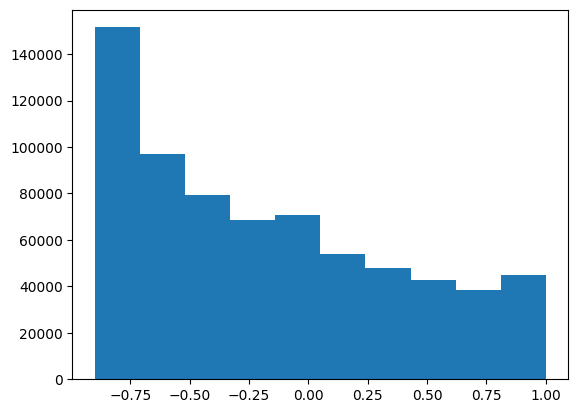

In [ ]:
v_dist, player_y, vel_y, h_dist = zip(*dists)
plt.hist(vel_y)
# plt.legend(['v_dist', 'y', 'vel_y', 'h_dist'])

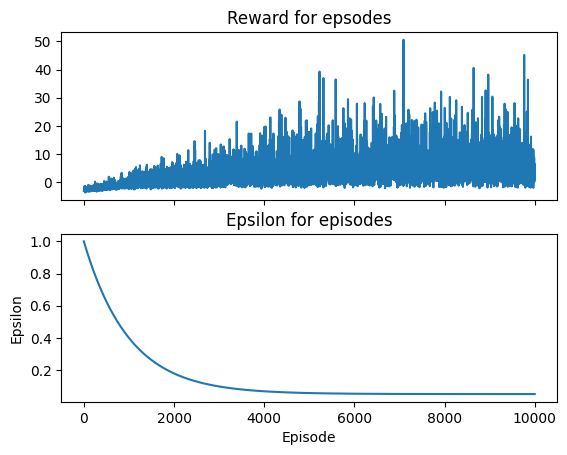

In [ ]:
plot(training_rewards, epsilons)

In [ ]:
(Q != 0).sum(), Q.size

(22, 28)

In [ ]:
env = wrap_env(FlappyBirdDiscreteEnv(render_mode="rgb_array"))
simulate_using_Q(env, Q, max_steps=500)